# 4.2 Elo prediction and the single Elimination Bracket

The long-term rank correlation value of the "Elo on the Single Elimination Bracket" in figure 4.1 is slightly below what is observed in other formats tested. In this notebook, I investigate the case starting with a simple clearly defined model and extending to larger simulation. It provides a first formal identification of what matchmaking overfitting can be. This is fascinating as the Elo and the single elimination bracket are two of the most famous, used and studied algorithms in competition, yet what is next presented is never mentioned nor considered.

## 4.2.1 Formal approach

The problem, when doing simulation with a small number of players, is that the distribution of levels has a massive impact on the ranking behavior. The importance of a population model becomes key. You can not simply draw values from a distribution - the sample size is too small to be representative.

### Probability Model
I decided to fix a smooth probability table. The model maintains a strict transitive relationship between the players. If P(A wins against B) > 0.5 and P(B wins against C) > 0.5 then P(A wins against C) > 0.5.

In [1]:
def matrixC1():
    table = []
    inc = 0.05
    for i in range(8):
        table.append([round(0.5-i*inc+j*inc,2) for j in range(8)])
    return table

c1 = matrixC1()
c1

[[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85],
 [0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8],
 [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75],
 [0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7],
 [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65],
 [0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6],
 [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55],
 [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]]

### Seedings in a Single Elimination Bracket

For n=8 players, there are $\frac{n!}{2^{n-1}}=\frac{8!}{2^7} = 315$ different initial seedings. One may think that with 8 players, we have $8!$ different ways to sort them. But a single elimination tree is a binary tree, with a lot of structural symmetries, and the model does not make a difference between a confrontation "$p_1$ versus $p_2$" and "$p_2$ versus $p_1$".

The reprSEB iterator produces *Equivalence class representatives* such that the highest seed of any subtree is always the left most element i.e

For a ~ b, defined below, reprSEB produces a but not b.<br>
a:= (0, 7, 3, 4, 1, 6, 2, 5)<br>
b:= (4, 3, 7, 0, 6, 1, 2, 5)<br>
Both seedings a and b results in the same Bracket:

```mermaid
graph BT
    %% Round 3 - final
    F["Final 0/3/4/7 vs 1/2/5/6 ......"]

    %% Round 2 - semi final
    SF1["SF1 Seed 0/7 vs 3/4   ......"] --> F
    SF2["SF2 Seed 1/6 vs 2/5   ......"] --> F
    
    %% Round 1 - quarter final
    QF1["QF1 Seed 0 vs Seed 7 ......"] --> SF1
    QF2["QF1 Seed 3 vs Seed 4 ......"] --> SF1
    QF3["QF1 Seed 1 vs Seed 6 ......"] --> SF2
    QF4["QF1 Seed 2 vs Seed 5 ......"] --> SF2
```

In [2]:
from utils.sebiter import reprSEB
from utils import treeprob as tp
import math

labels = list(range(8))
seedings = list(reprSEB(labels))
assert len(seedings) == len(set(seedings)) == math.factorial(len(labels)) // 2**(len(labels)-1) == 315

### Metrics

For a given seeding, I computed each player's probability to win the tournament and their expected score. The score is to be understood as the number of wins. For 8 players, the possible scores are:

- 0: for an elimination in the first round
- 1: for a win in the first round, and a loss in the 2nd
- 2: two wins and losing the final
- 3: for winning all games and the tournament.

For every seeding, we can then establish two theoretical rankings, one based on the probability to win the tournament, and one based on the expected score of each player.

In [3]:
def compute_bracket(seedings, matrix):
    results = []
    for seeding in seedings:
        bracket = tp.treeprob(seeding, matrix)
        results.append({
            'seeding': seeding,
            'ExpectedScore': [tp.expected_score(seed, bracket) for seed in labels],
            'WinProb': [tp.score_prob(seed, 3, bracket) for seed in labels] # win the final, i.e. win the 3rd round
        })
    return results

# Compute expexted score, WinProb of each player for any possible initial seedings.
results = compute_bracket(seedings, c1)

### Groundtruth

The consenus ranking can be computed by summing each player's probability to win against all potential opponents. This is similar to their expected socre in a random matchmaking or a round robin tournament.

In [4]:
def groundtruth(labels, matrix):
    """Natural Expected Score"""
    return [sum(matrix[seed]) for seed in labels]

GROUNDTRUTH = groundtruth(labels, c1)
GROUNDTRUTH

[5.4, 5.0, 4.6, 4.2, 3.8, 3.4, 3.0, 2.6]

In [5]:
from utils.metrics import argmin, argmax
from scipy import stats

def summary(results, labels, gt: list[float]):
    '''Summaries all probabilistic outcomes of single elimination bracket
    
    params:
        - results: list[dict[str, list[float]]]
            list of theoretical run of a tournament
        - labels: list[int]
            list of seeds
        - gt: list[float]
            list of unbiased theoretical strenght in the simulation
            
    returns:
        - fav: list[int]
            fav[i] indicates the number of seedings in which seed i is the player with highest probability to win the tournament.
        - scoring: list[int]
            scoring[i] indicates the number of seedings in which seed i is the player with highest expected score.
        - mins: list[int]
            mins[i] indicates the lowest probability seed i can have to win the tournament
        - maxs: list[int]
            maxs[i] indicates the highest probabilty seed i can have to win the tournament
        - worst_es: list[float]
            worst_es indicates the worst rank correlation between the expected score ranking and the groundtruth
        - worst_wp: list[float]
            worst_wpindicates the worst rank correlation betweenthe win probability ranking and the groundtruth
    '''
    NB = len(labels)
    fav = [0 for i in range(NB)]
    scoring = [0 for i in range(NB)]
    mins = [1 for i in range(NB)]
    maxs = [0 for i in range(NB)]
    worst_es = (None, 1.0)
    worst_wp = (None, 1.0)
    
    for result in results:
        for i in labels:
            mins[i] = min(mins[i], result['WinProb'][i])
            maxs[i] = max(maxs[i], result['WinProb'][i])
            if argmax(result['WinProb']) == i:
                fav[i] += 1
            if argmax(result['ExpectedScore']) == i:
                scoring[i] += 1
            result['GTCOR_ES'] = stats.kendalltau(gt, result['ExpectedScore'])[0]
            result['GTCOR_WP'] = stats.kendalltau(gt, result['WinProb'])[0]
            if result['GTCOR_WP'] < worst_wp[1]:
                worst_wp = (result['seeding'], result['GTCOR_WP'])
            if result['GTCOR_ES'] < worst_es[1]:
                worst_es = (result['seeding'], result['GTCOR_ES'])
    return fav, scoring, mins, maxs, worst_es, worst_wp

In [6]:
fav, scoring, mins, maxs, worst_es, worst_wp = summary(results, labels, GROUNDTRUTH)

print('worst seed regarding winner probabilities', worst_wp[0], worst_wp[1])
print('worst seed regarding expected score', worst_es[0], worst_es[1], '\n')

for i in labels:
    print(f'player {i} win prob:', f'min = {mins[i]:.4f},',
          f'max = {maxs[i]:.4f},',
          f'favorite in {fav[i]}',
          f', topscorer in {scoring[i]}')

worst seed regarding winner probabilities (0, 1, 2, 4, 3, 7, 5, 6) 0.7857142857142856
worst seed regarding expected score (0, 3, 1, 4, 2, 5, 6, 7) 0.2857142857142857 

player 0 win prob: min = 0.2560, max = 0.4014, favorite in 299 , topscorer in 205
player 1 win prob: min = 0.1798, max = 0.3096, favorite in 16 , topscorer in 68
player 2 win prob: min = 0.1235, max = 0.2390, favorite in 0 , topscorer in 32
player 3 win prob: min = 0.0851, max = 0.1806, favorite in 0 , topscorer in 9
player 4 win prob: min = 0.0570, max = 0.1344, favorite in 0 , topscorer in 1
player 5 win prob: min = 0.0364, max = 0.0915, favorite in 0 , topscorer in 0
player 6 win prob: min = 0.0218, max = 0.0607, favorite in 0 , topscorer in 0
player 7 win prob: min = 0.0118, max = 0.0354, favorite in 0 , topscorer in 0


### Observations

What can come as a surprise, is that for certain seedings, these two rankings are different from the consensus ranking implied by the model. The best player in the model is the favorite to win the tournament in 299 seedings out of 315. He has the highest expected score in 205. The Consensus Ranking, the Ranking of win probability, and the Ranking of expected score are all distinct from each other. Figure 4.2 shows rank correlation between statistical performances implied by seeding versus the model consensus.

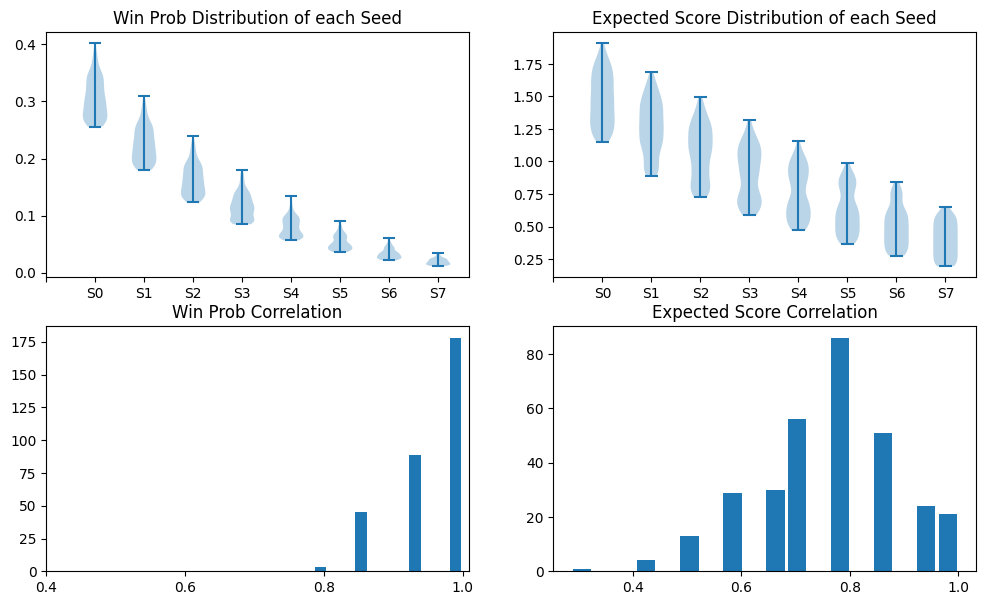

In [7]:
import matplotlib.pyplot as plt

NB = len(labels)

fig, axs = plt.subplots(2, 2, figsize=(12, 7))

win_dist = [[result['WinProb'][i] for result in results] for i in labels]
exp_dist = [[result['ExpectedScore'][i] for result in results] for i in labels]

axs[0][0].violinplot(win_dist)
axs[0][0].set_xticks(list(range(NB+1)), labels=[None]+[f'S{i}' for i in labels])
axs[0][0].set_title('Win Prob Distribution of each Seed')

axs[0][1].violinplot(exp_dist)
axs[0][1].set_xticks(list(range(NB+1)), labels=[None]+[f'S{i}' for i in labels])
axs[0][1].set_title('Expected Score Distribution of each Seed')

axs[1][0].hist(x=[result['GTCOR_WP'] for result in results], bins='auto', rwidth=0.85)
axs[1][0].set_xticks([0.4, 0.6, 0.8, 1.0])
axs[1][0].set_title('Win Prob Correlation')

axs[1][1].hist(x=[result['GTCOR_ES'] for result in results], bins='auto', rwidth=0.85)   
axs[1][1].set_xticks([0.4, 0.6, 0.8, 1.0])
axs[1][1].set_title('Expected Score Correlation')

plt.show()

## Figure 4.2:
In the single Elimination Bracket, seeding can impact player’s performances. The histogram shows the distribution of Kendall tau rank correlation between statistical ranking and the model consensus ranking. For 8 players we have 315 different seeding. There is no rating system, there is no game data. There is a player model and a scheduler here.


### Conclusion

A game scheduler leads to different interpretations of what "good" means. Theses meanings can be compared with rank correlation.

**The question is:** for a dataset resulting of a seeded single elimination bracket, what does Elo/Glicko/TrueSkill etc. learn - The WinProb, the ExpectedScore or the Consensus Ranking?

### 4.2.2 Simulation Goals

The proposed experiment is an illustration of matchmaking overfitting in a typical data formulation. The goal is to produce a biased dataset based on the previous conclusion. The bias introduced should be the sole consequence of the interaction of a scheduler with a ranking, an interaction that exists fundamentally in any competition. The algorithm chosen is Elo. Elo has a proven unique stationary distribution for random and skilled based matchmaking. It does converge to the consensus ranking. For a competition with elimination, there is no such proof.

The idea behind the analysis is that on one side, I evaluate the ranking from a strict empirical point of view: here is a dataset, here a ranking algorithm, how does it perform?

Alternatively, using the power of simulation, I generate every encounter never seen in the dataset. For each of these data points, I ask the model about the "real relationship" between the two involved players: Who is better? What is the probability that player1 beats player2? Then I ask the trained ranking to make a prediction for each of these data points outside of the matchmaking domain.

Finally, the question is, how does prediction on the evaluation set compare to the prediction of data never seen?

#### Evaluation

The evaluation method I used is the one presented by Valve for their [regional ranking](https://github.com/ValveSoftware/counter-strike_regional_standings). It is a common empirical practice. A ranking is trained with games played before a certain date, then evaluated on games played after that date. The measure used is win probability. Each data point prediction is grouped in bins of a given range. For example, if the range is 5%, the bin 50% contains all the games for which 47.5% ⪇ prediction ≤ 52.5%. We say that the Expected win rate is 50% for these games. The Observed win rate is simply the number of wins divided by the number of game in the bin. The Figure4.3 and its caption were taken directly from valve’s GitHub8. For the never seen data point outside the matchmaking domain, I compare the prediction of the ranking directly with the probability of the solver.

In [8]:
'''Dataset

Data collected during the RSSC protocol

We need to track learned rating, each encounters played (matchmaking domain), and the real level of each player in the update window
'''

from dataclasses import dataclass
from rstt import Ranking
from rstt.stypes import Event, SPlayer, SMatch
from utils.rssc import rssc
from typing import Any

@dataclass
class RsscResult:
    ratings: dict[SPlayer, Any]
    skills: dict[SPlayer, float]
    games: list[SMatch]

def datasets(ranking: Ranking, event: Event, ref: Ranking) -> RsscResult:
    return RsscResult(ratings={p: ranking.rating(p) for p in ref},
                      skills={p: ref.rating(p) for p in ref},
                      games=event.games(),)

In [9]:
'''
Evaluation

3 values are computed, the elo prediction, the win rate observed and the simulation model probabilities.
'''

from rstt import BasicElo, Duel, WIN
from rstt.stypes import Solver

def elo_predict(elo: BasicElo, duel: Duel) -> float:
    r1 = elo.datamodel.get(duel.player1())
    r2 = elo.datamodel.get(duel.player2())
    return elo.backend.expectedScore(r1, r2)

def true_prob(duel: Duel, solver: Solver) -> float:
    return solver.probabilities(duel)[solver.scores.index(WIN)]

def observedProb(outcomes: list[float]) -> float:
    return sum(outcomes)/len(outcomes)


## 4.2.3 Protocol

Considering the Bradly-Terry model, we generate n=64 players with a constant level, the game mode is "one-versus-one", and the solver is the LogSolver. The scheduler is a Single Elimination Bracket tournament seeded by an Elo ranking. We perform the *RSSC* loop with $depth = 1000$. Between two tournament editions $event_{i}, event_{i+1}$, the ranking is updated with the games played in $event_i$, and then used to seed $event_{i+1}$. This produces a dataset of $depth * (n-1) = 1000 * 63 =63'000$ ordered games.

For evaluation, we consider 4 moments $m=200,400,600,800$. For each of these moments we generate a training set with games played up to the tournament $event_{m}$, and a test set with all games played after it. We then train and evaluate an Elo ranking. 

**Remark:** the evaluation could have been done during the simulation process. We can ask the ranking to make predictions on the games before the updates. The choice to split the simulation from the evaluation was made to have a more realistic empirical approach. I can upload my dataset on the internet, someone else can download it and evaluate his ranking on it. The data production is strictly separated from the system evaluation (here the Elo ranking).

In [10]:
from rstt import SingleEliminationBracket as SEB
from rstt import BasicPlayer, BTRanking, LogSolver
import random

# Players
population = BasicPlayer.create(nb=64, level_dist=random.gauss, level_params={'mu':1500, 'sigma':500})
#population = BasicPlayer.create(nb=256, level_dist=random.gauss, level_params={'mu':1500, 'sigma':500})

# Solver
solver = LogSolver(base=10, lc=400)

# Test Ranking
elo = BasicElo('Elo', players=population)

# Sheduler
scheduler = SEB

# Interaction
depth = 1000

# Ground-Truth
gt = BTRanking('Consensus', population)
gt.plot()

# moments
splits = [200, 400, 600, 800]

----------- Consensus -----------
   0.           Dwain Hunt       2858
   1.       Johnnie Cortez       2607
   2.           Edna Clark       2598
   3.        David Houston       2469
   4.       Judith Hedrick       2304
   5.       Heather Moodie       2163
   6.          Jose Wilson       2159
   7.        William Brown       2155
   8.          James Johns       2155
   9.        Oliver Vargas       2096
  10.        Phil Bordelon       2087
  11.   Heather Gransberry       2070
  12.         Leon Philips       2067
  13.       Thomas Dingler       2054
  14.           Rosa Mills       1905
  15.         Carol Mccown       1890
  16.       Theresa Hinton       1844
  17.        Edwin Jimenez       1841
  18.        Leroy Gleason       1812
  19.          Jeremy Hill       1800
  20.    Gwendolyn Johnson       1797
  21.        Marilyn Young       1706
  22.     Francisco Gaytan       1678
  23.      Josephina Haley       1674
  24.     Michael Radcliff       1666
  25.          J

### Simulation Run

In [11]:
from functools import partial

results = rssc(name='SEBELO', seed=elo, cup=scheduler, solver=solver, depth=depth, metric=partial(datasets, ref=gt))
print('simulation done')

simulation done


In [12]:
from utils.tracking import Encounters
from utils.tracking import load_data, train_ranking, seen_data, unseen_data, domain
import numpy as np

@dataclass
class AbstentData:
    '''Represent Encounters not in the game dataset
    '''
    domain: Encounters
    predictions: list[float]
    truths: list[float]
    bias: np.array

@dataclass
class ExpVsObs:
    '''Represent metrics for the Expected versus Observed evaluation of rankings
    '''
    ranking: Ranking
    data: list[SMatch]
    training_domain: list[list[int]]
    test_domain: list[list[int]]
    predictions: list[float]
    outcomes: list[float]
    truths: list[float]
    synthetic: AbstentData

def biased_predictions(data: list[Duel], ref: Ranking, solver: Solver):
    '''Differences in probabilty between the predictions and the simulation model

    return list[float]
        a list of probability difference for each input games (data)
    '''
    nb = len(ref)
    bias = np.full((nb, nb), -1, dtype=float)
    for duel in data:
        p1, p2 = duel.player1(), duel.player2()
        i, j = ref[p1], ref[p2]
        bias[i, j] = abs(elo_predict(ref, duel) - true_prob(duel, solver))
    return bias

def eval_elo(elo: BasicElo, train: list[Duel], test:list[Duel], solver: Solver) -> ExpVsObs:
    '''Function to perform analysis
    '''
    sd = seen_data(train, elo)
    ud = unseen_data(sd, elo)
    synthetic = [Duel(elo[i], elo[j]) for (i, j) in ud.keys()]
    
    nodata = AbstentData(domain=domain(ud, elo),
                         predictions=[elo_predict(elo, duel) for duel in synthetic],
                         truths=[true_prob(duel, solver) for duel in synthetic],
                         bias = biased_predictions(synthetic, elo, solver)
                        )
    return ExpVsObs(ranking=elo,
                    data=test,
                    training_domain = domain(seen_data(train, elo), elo),
                    test_domain = domain(seen_data(test, elo), elo),
                    predictions = [elo_predict(elo, duel) for duel in test],
                    outcomes = [1 if duel.winner() == duel.player1() else 0 for duel in test],
                    truths = [true_prob(duel, solver) for duel in test],
                    synthetic = nodata
                   )

# Analysis
measures: list[ExpVsObs] = []
for split in splits:
    training_set = load_data(results[:split])
    telo = train_ranking(BasicElo(f'trained {split}'), results[:split])
    print('elo trained')
    test_set = load_data(results[split:])
    print('test set loaded')

    measures.append(eval_elo(telo, training_set, test_set, solver))

elo trained
test set loaded
elo trained
test set loaded
elo trained
test set loaded
elo trained
test set loaded


## 4.2.3 Results

All 4 moments of evaluation show similar results. First, we can note that from an empirical point of view- Expected versus Observed Win Rate, the ranking is perfectly tuned. This should not be a surprise. It is a synthetic dataset. Players do not have notions of injury or mental form. They have a constant level. The game is perfectly balanced, there is no home or away advantage, no referring interference and no cheater. When the ranking is asked to make predictions on confrontations that are neither in the training nor the test set, we can see that most of the predictions are close to the model probabilities (around the identity x = y).

However, there are some outlier points. The ranking predicted a 50% win chance for several games where the real probability, the one computed by the model in simulation, is close to 0 or a 100%. The ranking confuses balance game with guaranteed win. This is the worst possible assessement of players skills relationship. 

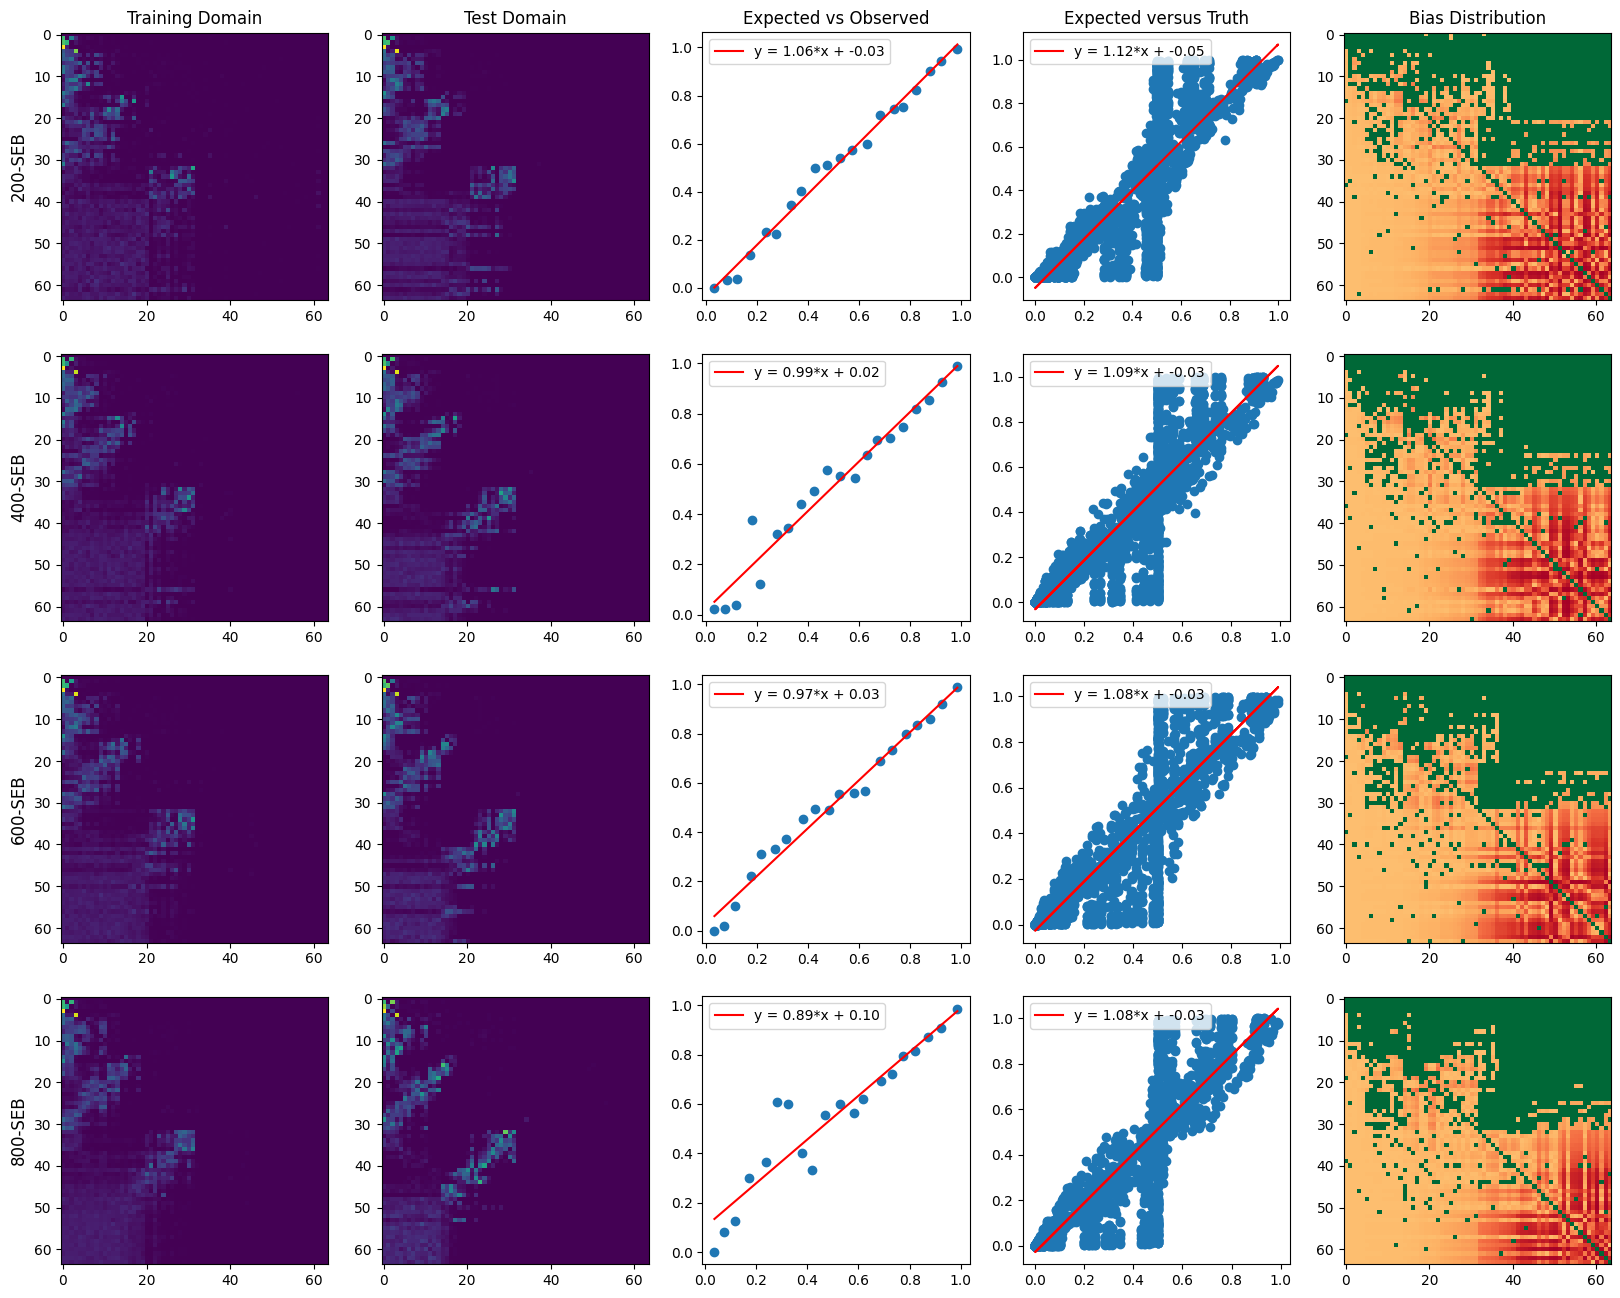

In [13]:
def expected_vs_observed(predictions: list[float], outcomes: list[float], bins: int): 
    '''prepare predictions for visualisation
    '''
    expected, observed = [], []
    inc = 100//bins
    for i in range(0, bins):
        lower = (i * inc)/100
        upper = ((i+1) * inc)/100
        
        indices = [i for i, val in enumerate(predictions) if lower <= val < upper]
        scores = [outcomes[i] for i in indices]
        preds = [predictions[i] for i in indices]
        if preds:
            expected.append(sum(preds) / len(preds))
            observed.append(sum(scores)/ len(scores))
    return expected, observed


cols_name = ['Training Domain', 'Test Domain', 'Expected vs Observed', 'Expected versus Truth', 'Bias Distribution']
rows_name = [f'{split}-SEB' for split in splits]

fig, axs = plt.subplots(4,5, figsize=(20, 16))

for ax, col in zip(axs[0], cols_name):
    ax.set_title(col)
for ax, row in zip(axs[:,0], rows_name):
    ax.set_ylabel(row, rotation=90, size='large')


for res, ax in zip(measures, axs):
    ax[0].imshow(res.training_domain)
    ax[1].imshow(res.test_domain)

    exp, obs = expected_vs_observed(res.predictions, res.outcomes , bins=20)
    axis = np.array(exp)
    lr = stats.linregress(exp, obs)
    ax[2].plot(exp, obs, 'o')
    ax[2].plot(axis, lr.intercept + lr.slope*axis, 'r', label=f'y = {lr.slope:.2f}*x + {lr.intercept:.2f}')
    ax[2].legend()
    
    exp, obs = res.synthetic.predictions, res.synthetic.truths
    axis = np.array(exp)
    lr = stats.linregress(exp, obs)
    ax[3].plot(exp, obs, 'o')
    ax[3].plot(axis, lr.intercept + lr.slope*axis, 'r', label=f'y = {lr.slope:.2f}*x + {lr.intercept:.2f}')
    ax[3].legend()

    ax[4].imshow(res.synthetic.bias, cmap='RdYlGn_r', vmin=-1, vmax=0.5)
    
plt.show()

### Figure 4.4: Empirical versus Simulation evaluation.

Each row is a different moment of the simulation. First columns display the matchmaking domain of the training set as an heatmap of encounter (playeri, playerj). The second columns display the matchmking domain of the test set. In the 3rd columns - in the midlle - "Expected versus Observed" measure - dots are bins of games. The 4th columns - "Expected versus Ground Truth" - each dot is single game (playeri, playerj ) absent from the training and the evaluation sets.
The final columns display the differences in probability between the prediction of the elo ranking and the simulation model for each possible encounters that are absent form the training set.

Although we have an empiricaly perfectly tuned ranking, it fails to correctly capture every possible encounter. Indeed, we can observe (0.5, 0.0)&(0.5, 1.0) dots, which means the ranking believes some games are balanced when in fact one of the players has a 100% chance to win the encounter.

In the last columns we can see the *Overfiting Domain* (in green) and which domain the ranking does not generalize to (in red).

## Further Remarks

### (A) Rank differences
Instead of probabilty difference, it is worth measuring a rank difference between the learned elo and the consensus ranking. The rank is usually what a player is interested in and what he can see.

I compare the rank difference of our elo trained on 1000 single elimination bracket with the rank difference of the same elo ranking, with just one more Round Robin played.

In [14]:
from rstt import RoundRobin

# current rank diff in an elo syste,
sebelo_rank_diff = [gt[p]-elo[p] for p in gt]

# play one round robin
rr = RoundRobin('fix elo', elo, solver)
rr.registration(elo.players())
rr.run()

# compute new rank diff
elo.update(games=rr.games())
rrelo_rank_diff = [gt[p]-elo[p] for p in gt]

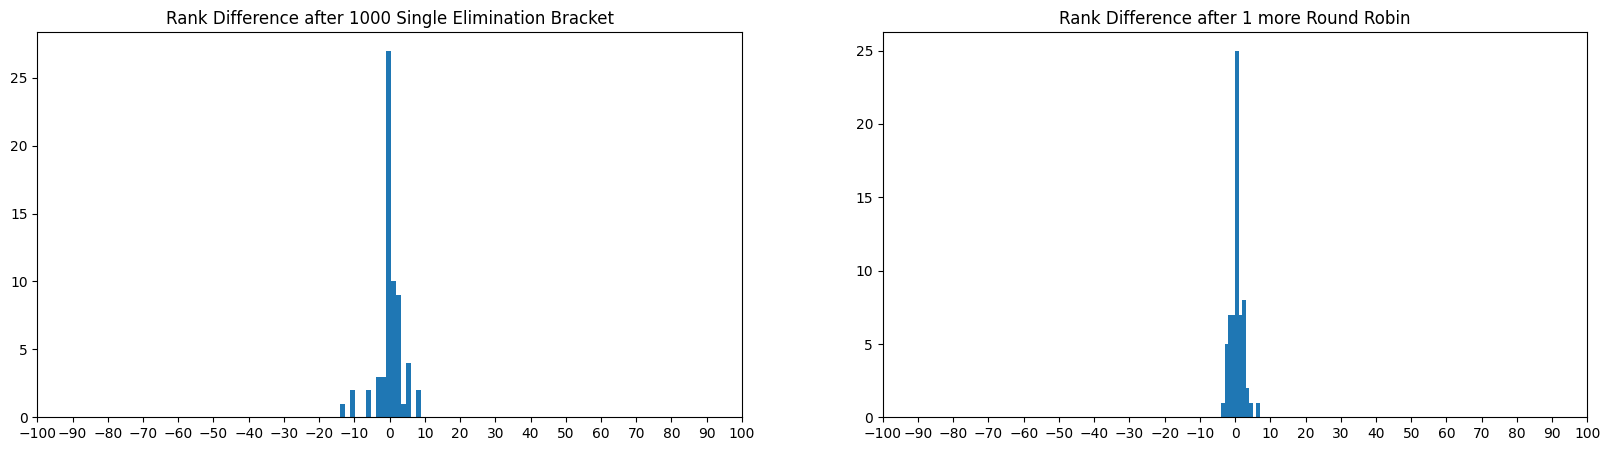

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].hist(sebelo_rank_diff, bins='auto')
axs[0].set_xticks(list(range(-100, 101, 10)))
axs[0].set_title('Rank Difference after 1000 Single Elimination Bracket')
axs[1].hist(rrelo_rank_diff, bins='auto')
axs[1].set_xticks(list(range(-100, 101, 10)))
axs[1].set_title('Rank Difference after 1 more Round Robin')
plt.show()

### Discussion

As we can see on the left, the elo trained on about 63'000 miss rank player up to 15 places, which is more than a 20% error for 64 players. only about a third of the player are corretly ranked. On the right, we can see the elo adjustement after 2000 more games from another mathmaking domain, a round robin. Generaly speaking the distribution is more tight and centered indicating a way better assesement of the true rank of the players. 

The scheduler underlying a game data set is not a detail when evaluation ranking, independantly of the metrics used of evaluation or even the methodlogy of research. The interaction of a ranking with the data it produces is a critical element of any rigorous research. 

### (B) Player model for small population

The following highlights the importance of setting the player model for small population. It reproduces *'the formal approach'* with 5 different populations and plotting in addition an heatmap of win probabilities.

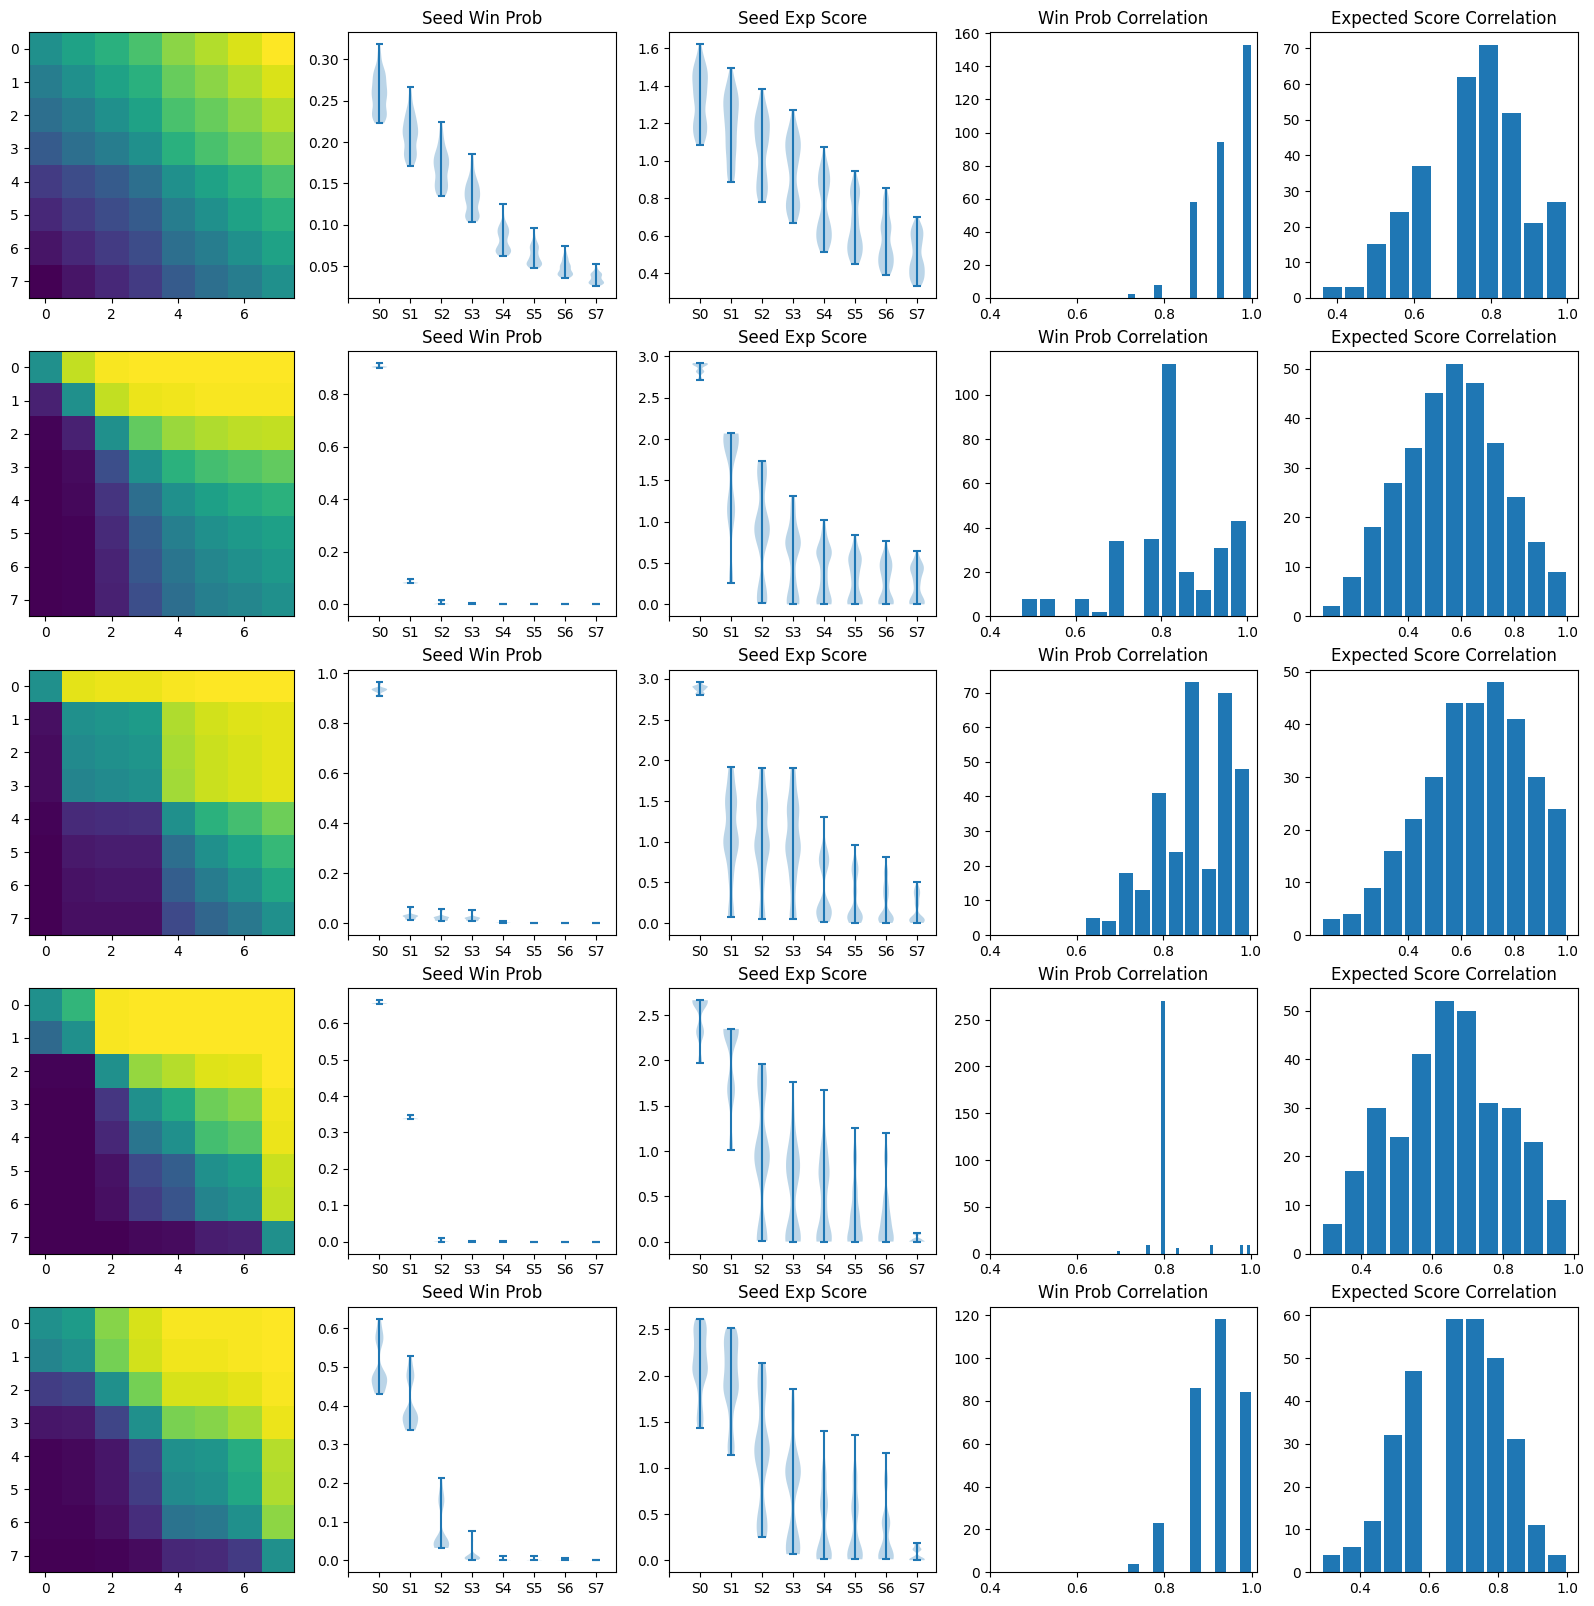

In [16]:
from utils import visualisation as visul

def prob_matrix(gt: BTRanking) -> list[list[float]]:
    '''convert rstt model to probability matrix'''
    matrix = []
    for p1 in gt:
        line = []
        for p2 in gt:
            if p1 != p2:
                line.append(round(LogSolver().probabilities(Duel(p1, p2))[0], 2))
            else:
                line.append(0.5)
        matrix.append(line)
    return matrix

# 5 test model
models = [
    prob_matrix(BTRanking('linear', [BasicPlayer('Seed{i}', 1000+l) for i, l in zip(labels, [-100, -75, -50, -25, 25, 50, 75, 100])])),
    prob_matrix(BTRanking('elitist', [BasicPlayer('Seed{i}', 1000+l) for i, l in zip(labels, [0, 25, 50, 100, 200, 400, 800, 1200])])),
    prob_matrix(BTRanking('gauss1', BasicPlayer.create(nb=8))),
    prob_matrix(BTRanking('gauss2', BasicPlayer.create(nb=8))),
    prob_matrix(BTRanking('gauss3', BasicPlayer.create(nb=8))),
]

# run, analysis & plot
fig, axs = plt.subplots(len(models), 5, figsize=(20, 20))
for matrix, row in zip(models, axs):
    truth = groundtruth(labels, matrix)
    results = compute_bracket(seedings, matrix)
    fav, scoring, mins, maxs, worst_es, worst_wp = summary(results, labels, truth)
    visul.visualize_bracket_analysis(results, labels, matrix, row)
plt.show()

In [17]:
# print a model summary
model = 2 #len(models)
matrix = models[model]
truth = groundtruth(labels, matrix)
results = compute_bracket(seedings, matrix)
fav, scoring, mins, maxs, worst_es, worst_wp = summary(results, labels, truth)
visul.summary(fav, scoring, mins, maxs, worst_es, worst_wp, labels)

worst seed regarding winner probabilities (0, 5, 1, 6, 2, 4, 3, 7) 0.6182840223353118
worst seed regarding expected score (0, 1, 2, 3, 4, 5, 6, 7) 0.07142857142857142 

player 0 win prob: min = 0.9080, max = 0.9672, favorite in 315 , topscorer in 315
player 1 win prob: min = 0.0124, max = 0.0620, favorite in 0 , topscorer in 0
player 2 win prob: min = 0.0082, max = 0.0554, favorite in 0 , topscorer in 0
player 3 win prob: min = 0.0071, max = 0.0534, favorite in 0 , topscorer in 0
player 4 win prob: min = 0.0002, max = 0.0095, favorite in 0 , topscorer in 0
player 5 win prob: min = 0.0000, max = 0.0015, favorite in 0 , topscorer in 0
player 6 win prob: min = 0.0000, max = 0.0008, favorite in 0 , topscorer in 0
player 7 win prob: min = 0.0000, max = 0.0003, favorite in 0 , topscorer in 0
